In [45]:
#!pip install seaborn
#!pip install scikit-learn
#!pip install opencv-python

In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import Reshape, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import InceptionV3
import cv2
import random
import pickle
from sklearn.metrics import confusion_matrix

In [47]:
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [48]:
def luv_color(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image = cv2.addWeighted(image, 3, cv2.GaussianBlur(image, (0,0) ,256/10), -3, 128)
    return image

In [50]:
# Caminhos das pastas contendo as imagens de treinamento e validação
train_data_dir = "../data/subset/treino"
validation_data_dir = "../data/subset/validacao"

batch_size = 64

def preprocess_image(image):
    #image = hair_removal_augmentation(image)
    #image = luv_color(image)
    # Normalizar a imagem entre 0 e 1
    image = image / 255.0
    return image

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range=0.8,  # Valor máximo de cisalhamento das imagens
    zoom_range=0.2,  # Faixa de zoom aplicada às imagens
    brightness_range=[0.7, 1.3],  # Faixa de brilho aplicada às imagens
    fill_mode='nearest',  # Modo de preenchimento de pixels para transformações geométricas
    preprocessing_function=preprocess_image,  
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, train_generator.num_classes), dtype=tf.float32)
    )
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range=0.8,  # Valor máximo de cisalhamento das imagens
    zoom_range=0.2,  # Faixa de zoom aplicada às imagens
    brightness_range=[0.7, 1.3],  # Faixa de brilho aplicada às imagens
    fill_mode='nearest',  # Modo de preenchimento de pixels para transformações geométricas
    preprocessing_function=preprocess_image,  
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: validation_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, validation_generator.num_classes), dtype=tf.float32)
    )
)

Found 24489 images belonging to 2 classes.
Found 8637 images belonging to 2 classes.


In [33]:
# Criar modelo base Inception-V4
base_model = InceptionV3(
    input_shape=(299, 299, 3),
    weights='imagenet',
    include_top=False
)

# Congelar todas as camadas do modelo base
for layer in base_model.layers:
    layer.trainable = False

# Adicionar camadas extras ao modelo
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(2, activation='sigmoid')(x)

# Criar o modelo final
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

# Compilar o modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(), 'AUC'])
# Callbacks
cb_early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

# Define o caminho para salvar os checkpoints
checkpoint_path = "../models/checkpoint"

# Callback para salvar os checkpoints
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

callbacks_list = [checkpoint_callback, cb_early_stopper]

# Verifica se há um checkpoint existente para carregar
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_path)
if latest_checkpoint is not None:
    print("Carregando checkpoint existente:", latest_checkpoint)
    model.load_weights(latest_checkpoint)

In [34]:
class_weight_dict = {0: 0.5090233545647559, 1: 28.205882352941178}

In [35]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks_list,
    validation_steps=validation_generator.n // batch_size,
    class_weight = class_weight_dict
)

Epoch 1/100


2023-06-23 22:32:30.579173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


78/78 [==============================] - ETA: 0s - loss: 1.1452 - recall_4: 0.3271 - auc: 0.2883

2023-06-23 22:33:01.563068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.89865, saving model to ../models/checkpoint
78/78 [==============================] - 52s 639ms/step - loss: 1.1452 - recall_4: 0.3271 - auc: 0.2883 - val_loss: 1.8987 - val_recall_4: 0.2160 - val_auc: 0.1260
Epoch 2/100
78/78 [==============================] - ETA: 0s - loss: 0.9382 - recall_4: 0.4601 - auc: 0.4436
Epoch 2: val_loss improved from 1.89865 to 1.37611, saving model to ../models/checkpoint
78/78 [==============================] - 45s 578ms/step - loss: 0.9382 - recall_4: 0.4601 - auc: 0.4436 - val_loss: 1.3761 - val_recall_4: 0.3752 - val_auc: 0.3312
Epoch 3/100
78/78 [==============================] - ETA: 0s - loss: 0.8538 - recall_4: 0.5113 - auc: 0.5185
Epoch 3: val_loss did not improve from 1.37611
78/78 [==============================] - 79s 1s/step - loss: 0.8538 - recall_4: 0.5113 - auc: 0.5185 - val_loss: 1.5411 - val_recall_4: 0.3332 - val_auc: 0.2939
Epoch 4/100
78/78 [==============================] - ETA: 0s - loss: 0.

In [37]:
# Salvar o histórico de treinamento em um arquivo separado
history_path = '../models/history_InceptionV4_100.pickle'
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

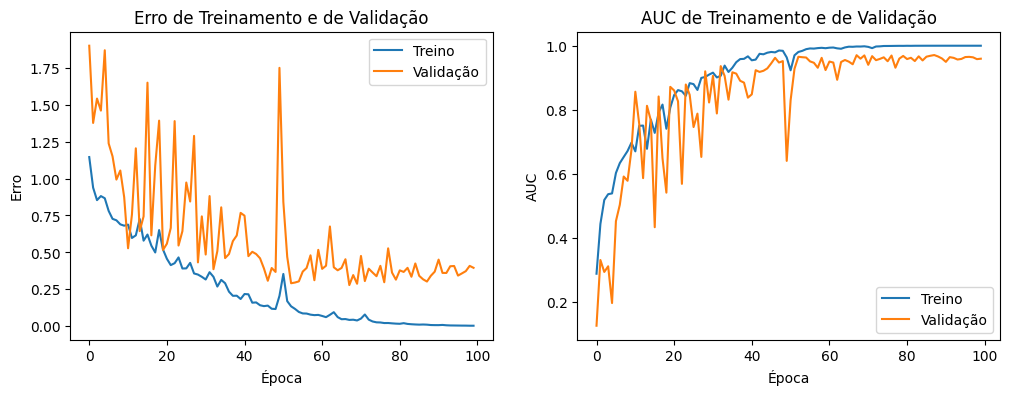

In [38]:
# Plotting AUC and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.xlabel('Época')
plt.ylabel('Erro')
plt.title('Erro de Treinamento e de Validação')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Treino')
plt.plot(history.history['val_auc'], label='Validação')
plt.xlabel('Época')
plt.ylabel('AUC')
plt.title('AUC de Treinamento e de Validação')
plt.legend()
plt.show()

In [39]:
# Evaluation and Metrics
predictions = model.predict(validation_generator)
y_true = validation_generator.classes
y_pred = predictions.argmax(axis=1)

confusion_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

false_positive_rate = confusion_mat[0, 1] / (confusion_mat[0, 1] + confusion_mat[0, 0])
print("False Positive Rate:", false_positive_rate)

2023-06-24 00:04:08.961164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


52/52 [==============================] - 18s 342ms/step
Confusion Matrix:
[[2962  261]
 [  50    5]]
False Positive Rate: 0.08098045299410488


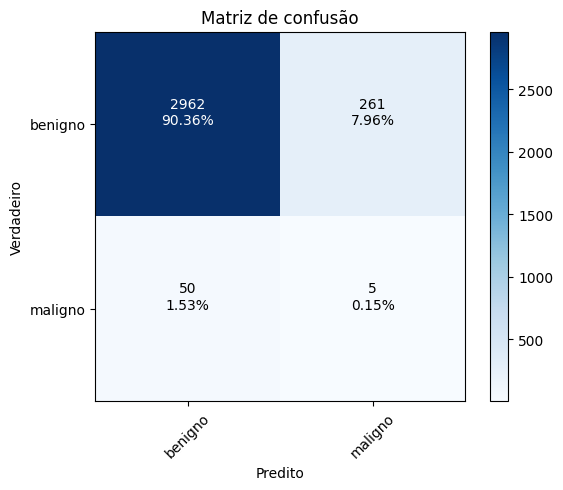

In [40]:
# Obtém as classes reais e as classes previstas
y_true = validation_generator.classes
y_pred = predictions.argmax(axis=1)

# Calcula a matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with total numbers
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Obtém os rótulos das classes
class_names = validation_generator.class_indices
class_names = list(class_names.keys())

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Calculate the total numbers in each group
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]

# Add the total numbers to the plot
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(cm.shape[0], cm.shape[1])

# Show the total numbers in each group
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, labels[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()